**Ціль:** Провести технічний аналіз акцій автомобільної компанії Ford Motor Company.


**Джерело даних:** https://www.alphavantage.co/

Проводимо ініціалізацю проекту, підключивши всі необхідні бібліотеки і задавши налаштування для зручного відображення.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_finance import candlestick2_ohlc, candlestick_ohlc
import matplotlib.dates as mdates
import time

In [2]:
%config InlineBackend.figure_format = 'svg'
pd.options.display.max_rows = 10
plt.rc('figure', figsize=(8, 5))

На сайті Alpha Vantage потрібно отримати спеціальний *api-ключ* за допомогою якого буде здійснюватись доступ до даних. Також потрібно знайти ярлик (symbol) компанії Ford.

In [3]:
api_key = 'PK4CSDV4WTP2HNPS'
ford_symbol = 'F'

Опишемо функцію для отримання даних з сайту Alpha Vantage.

In [4]:
def get_alpha_vantage(
        apikey, symbol,
        function='TIME_SERIES_DAILY',
        outputsize='compact',
        datatype='csv',
        **kwargs):
    base_url = 'https://www.alphavantage.co/query?'
    
    req = f'{base_url}function={function}&outputsize={outputsize}&datatype={datatype}&symbol={symbol}&apikey={apikey}'
    for key, val in kwargs.items():
        req += '&' + str(key) + '=' + val

    data = pd.read_csv(req, index_col='timestamp', parse_dates=True)    
    return data.sort_index()

Щоб отримати дані достатньо викликати данну функції з відповіднми параметрами.

In [5]:
ford_data = get_alpha_vantage(api_key, ford_symbol, outputsize='full')

In [6]:
ford_data

,open,high,low,close,volume
timestamp,,,,,
1998-01-02,48.69,48.870,48.12,48.250,3388033
1998-01-05,48.25,48.500,47.81,48.500,4463654
1998-01-06,48.25,48.250,47.00,47.690,4746085
1998-01-07,47.37,47.620,46.31,47.120,5791534
1998-01-08,46.31,46.620,44.94,45.060,6208020
...,...,...,...,...,...
2019-03-22,8.63,8.670,8.52,8.540,41963991
2019-03-25,8.56,8.650,8.47,8.510,45849484
2019-03-26,8.54,8.760,8.54,8.760,47852114


Ми успішно отримали дані про ціни компанії Ford в період з 1998 до сьогоднішнього дня. Для візуального аналізу побудуємо графік.

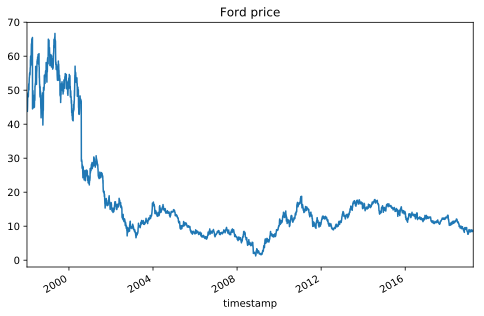

In [7]:
ford_data['close'].plot(title = 'Ford price')

На графіку видно, що ціни акцій Ford стабільно падають з 2014 року. Для аналізу візьмемо саме цей період.

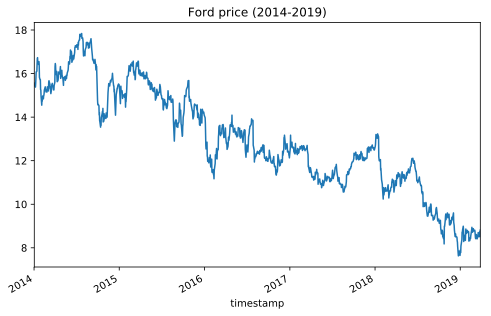

In [34]:
ford = ford_data.copy(deep=True)['2014':]
ford['close'].plot(title = 'Ford price (2014-2019)')

In [35]:
ford.describe()

,open,high,low,close,volume
count,1318.000000,1318.000000,1318.000000,1318.000000,1.318000e+03
mean,12.952485,13.063210,12.821060,12.941210,3.536710e+07
std,2.371240,2.378794,2.364666,2.372083,1.571777e+07
min,7.530000,7.850000,7.410000,7.630000,2.735950e+05
25%,11.282500,11.390000,11.185000,11.280000,2.501906e+07
50%,12.610000,12.700000,12.500000,12.600000,3.191117e+07
75%,15.010000,15.107500,14.830000,14.990000,4.205790e+07
max,18.010000,18.120000,17.780000,17.840000,1.421686e+08


З період 2014-2019 ціни на акції компанії Ford знаходились в межах 7.50-18 USD.


Опишемо функцію побудови японських свічок для наявних даних.

In [20]:
def plot_candlestick(data):
    format_data = data.copy()
    format_data['date']=format_data.index
    format_data = format_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    format_data['date']=format_data['date'].apply(mdates.date2num)
    ax = plt.axes()
    plt.xticks(rotation=80)
    interval = len(data)//10
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
   
    
    plt.ylabel('Price USD')
    plt.xlabel('Date')
    candlestick_ohlc(
        ax,
        quotes=format_data.values,
        width=0.5,
        colorup='g',
        colordown='r')

Застосуємо цю функцію для даних за 2019 рік

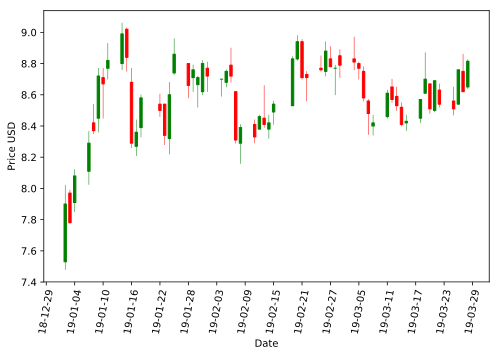

In [37]:
plot_candlestick(ford['2019':])

Також опишемо функцію яка обчислює лінії Боліджера та функцію для побудови графіку цих ліній.

In [78]:
def bollinger_bands(series, MA=20, k=2):
    sma =  series.rolling(window=MA).mean()
    rstd = series.rolling(window=MA).std()
    lower_band = sma - k * rstd
    upper_band = sma + k * rstd
    return lower_band, sma, upper_band

def plot_bollinger(series, color='#6666FF', symbol=''):

    lower_band, sma, upper_band = bollinger_bands(series)

    ax = plt.axes()

    ax.set_title('{} Price and Bollinger Bands'.format(symbol))
    ax.set_xlabel('Date')
    ax.set_ylabel('SMA and Bollinger Bands')
    plt.xticks(rotation=80)
    interval = len(series)//10
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
   

    ax.plot(series.index, series, color=color, linewidth=1)

    ax.fill_between(
            series.index, lower_band, upper_band,
            color=color, alpha=0.1)
    ax.plot(
            series.index, lower_band, upper_band,
            color=color, linewidth=1, alpha=0.4)
    ax.plot(series.index, sma,
            color='red', linewidth=2, alpha=0.8)

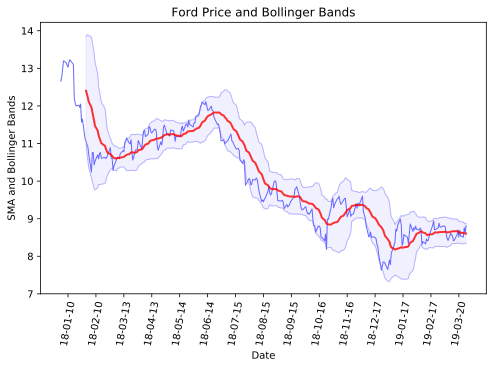

In [76]:
plot_bollinger(ford['2018':]['close'], symbol='Ford')

Акції майже весь час знаходять всередині рукавів, для обчислення днів коли акції виходять за межі опишемо відповідну функцію

In [183]:

lower_band, sma, upper_band = bollinger_bands(ford)

indicator=pd.DataFrame(index=ford.index)
indicator['status']=0
# indicator['lower_band']=lower_band

for index in ford.index:
    if ford.loc[index]['close']<lower_band.loc[index]['close']:
        indicator.loc[index]['status']=-1
        break
    if ford.loc[index]['close']>upper_band.loc[index]['close']:
        indicator.loc[index]['status']=1
        break

indicator[['status'] > 0]


TypeError: '>' not supported between instances of 'list' and 'int'

In [89]:
check_bollinger(ford)

,open,high,low,close,volume
timestamp,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN
2014-01-06,NaN,NaN,NaN,NaN,NaN
2014-01-07,NaN,NaN,NaN,NaN,NaN
2014-01-08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2019-03-22,8.937607,9.030285,8.842895,8.922071,6.313337e+07
2019-03-25,8.922647,9.015806,8.815534,8.907536,6.180863e+07
2019-03-26,8.909071,8.988513,8.793098,8.883047,6.202860e+07
